In [0]:
import pandas as pd
import numpy as np
import pickle
import gzip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open('/content/drive/My Drive/dl-ims/test_subjects','rb') as f:
               images = pickle.load(f)


#### Subject IDs

In [5]:
im_name_list =[]

for x1 in images:
    im_name_list.append(x1)
im_name_list

['OAS30001',
 'OAS30002',
 'OAS30004',
 'OAS30005',
 'OAS30006',
 'OAS30007',
 'OAS30008',
 'OAS30019',
 'OAS30022',
 'OAS30024',
 'OAS30027']

#### Making training and test sets

In [6]:
pixels=np.zeros((1, 120, 160, 120))
for name in im_name_list:
    pixels= np.append(pixels ,np.reshape(images[name]['image'], (1, 120, 160, 120) ), axis=0)

input_ims= pixels[1:12,:,:,:] 
input_ims.shape

(11, 120, 160, 120)

In [7]:
x_train = input_ims[0:9,:,:,:]
x_train.shape

(9, 120, 160, 120)

In [8]:
x_test=input_ims[9:12,:,:,:]
x_test.shape

(2, 120, 160, 120)

In [0]:
x_test= np.reshape(x_test, (2, 120, 160, 120, 1) )

#### Making target values

In [10]:
y_train= [images[key]['group'] for key in images.keys()]
y_test = y_train[-2:]
y_test

['AD', 'AD']

In [11]:
y_train = y_train[:9]
y_train

['CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'AD', 'AD']

In [12]:
def convert_numeric(x):
    if x == "AD":
        return 1
    elif x == "CN":
        return 0
    else:
        return x
    
    
y_train = list(map( convert_numeric, y_train))
y_train

[0, 0, 0, 0, 0, 0, 0, 1, 1]

In [13]:
y_test = list(map( convert_numeric, y_test))
y_test

[1, 1]

In [14]:
len(input_ims)

11

In [15]:
#looking into first image
first_im=images['OAS30001']
first = first_im['image']
first.shape

(120, 160, 120)

In [0]:
first_modified= np.reshape(first, (120, 160, 120 , 1))

In [0]:
x_train = np.reshape(x_train, (9, 120, 160, 120, 1) )

#### Building Encoder

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, Conv3DTranspose, UpSampling3D, Reshape
from keras.layers import Input


input_img = Input(shape= (120, 160, 120 , 1))
x = Conv3D(10, (3,3,3), activation='relu', padding='same')(input_img)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

encoded_shape = K.int_shape(x)

x = Flatten()(x)

x = Dense(32, activation='selu')(x)
x= Dense(16, activation='selu')(x)
encoded = Dense(2, activation='selu')(x)


encoder=Model(input_img, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 40, 30, 10)    0   

#### Building decoder

In [24]:
encoded_input= Input(shape=(2,))
x = Dense(16, activation='selu')(encoded_input)
x= Dense(32, activation='selu')(x)
x= Dense(np.prod(encoded_shape[1:]))(x)
x= Reshape((encoded_shape[1], encoded_shape[2], encoded_shape[3], encoded_shape[4]))(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_12 (Dense)             (None, 45000)             1485000   
_________________________________________________________________
reshape_2 (Reshape)          (None, 15, 20, 15, 10)    0         
_________________________________________________________________
conv3d_transpose_5 (Conv3DTr (None, 15, 20, 15, 10)    2710      
_________________________________________________________________
up_sampling3d_4 (UpSampling3 (None, 30, 40, 30, 10)    0   

#### Building Autoencoder

In [25]:
autoencoder= Model(input_img, decoder(encoder(input_img)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
encoder (Model)              (None, 2)                 1446294   
_________________________________________________________________
decoder (Model)              (None, 120, 160, 120, 1)  1493993   
Total params: 2,940,287
Trainable params: 2,940,287
Non-trainable params: 0
_________________________________________________________________


In [26]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

hist= autoencoder.fit(x_train, x_train, epochs=200, verbose=1, validation_data=(x_test, x_test))


Train on 9 samples, validate on 2 samples
Epoch 1/200
9/9 [==============================] - 2s 188ms/step - loss: 0.6974 - val_loss: 0.6910
Epoch 2/200
9/9 [==============================] - 1s 120ms/step - loss: 0.6901 - val_loss: 0.6875
Epoch 3/200
9/9 [==============================] - 1s 115ms/step - loss: 0.6831 - val_loss: 0.6790
Epoch 4/200
9/9 [==============================] - 1s 115ms/step - loss: 0.6691 - val_loss: 0.6608
Epoch 5/200
9/9 [==============================] - 1s 116ms/step - loss: 0.6465 - val_loss: 0.6277
Epoch 6/200
9/9 [==============================] - 1s 116ms/step - loss: 0.6187 - val_loss: 0.5788
Epoch 7/200
9/9 [==============================] - 1s 116ms/step - loss: 0.5912 - val_loss: 0.5242
Epoch 8/200
9/9 [==============================] - 1s 117ms/step - loss: 0.5644 - val_loss: 0.4787
Epoch 9/200
9/9 [==============================] - 1s 116ms/step - loss: 0.5374 - val_loss: 0.4454
Epoch 10/200
9/9 [==============================] - 1s 116ms/step -

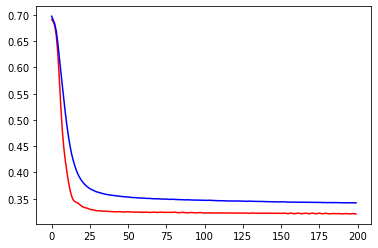

In [29]:
plt.plot(hist.history['val_loss'], 'r', hist.history['loss'], 'b')